/var/folders/vx/8tvlcr0x6t97b594jpsf3xh00000gn/T/ipykernel_54047/647301517.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bank.groupby("age_group")["y"]


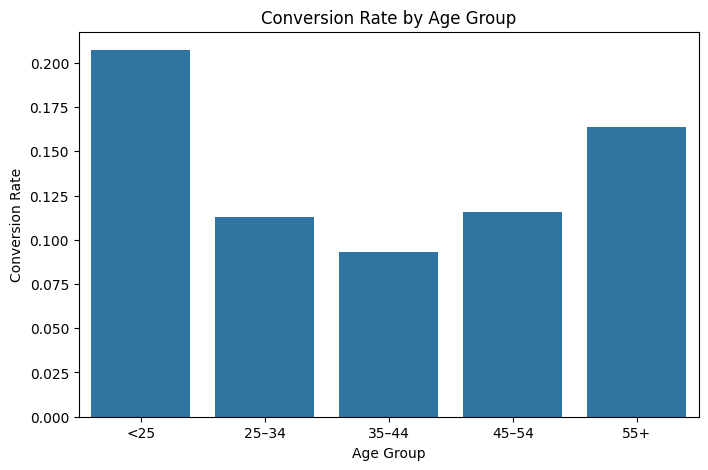

/var/folders/vx/8tvlcr0x6t97b594jpsf3xh00000gn/T/ipykernel_54047/647301517.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bank.groupby("campaign_bin")["y"]


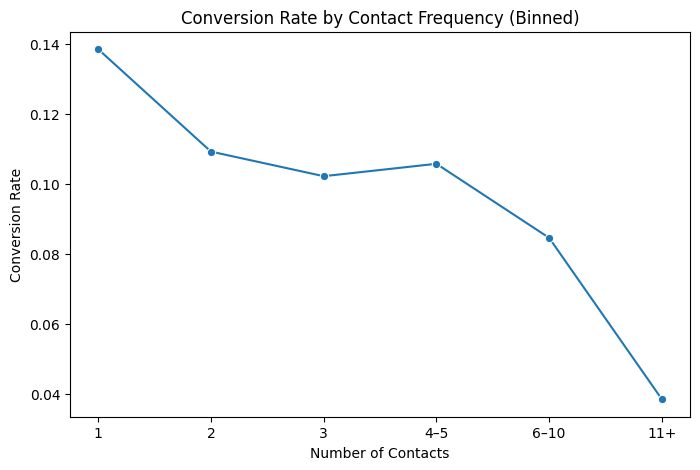

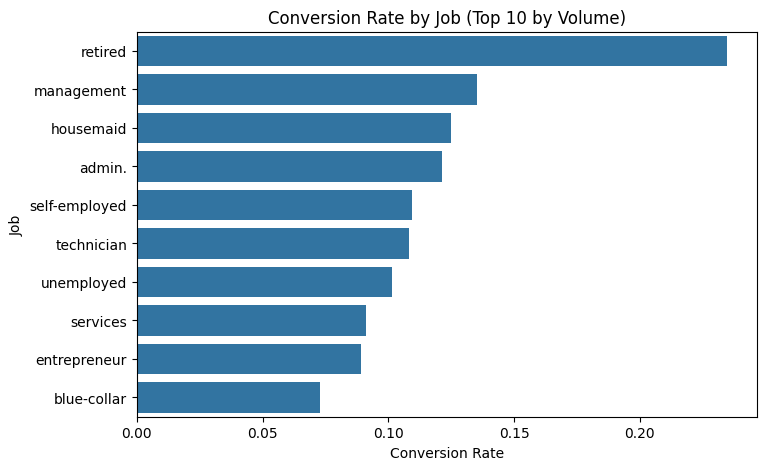

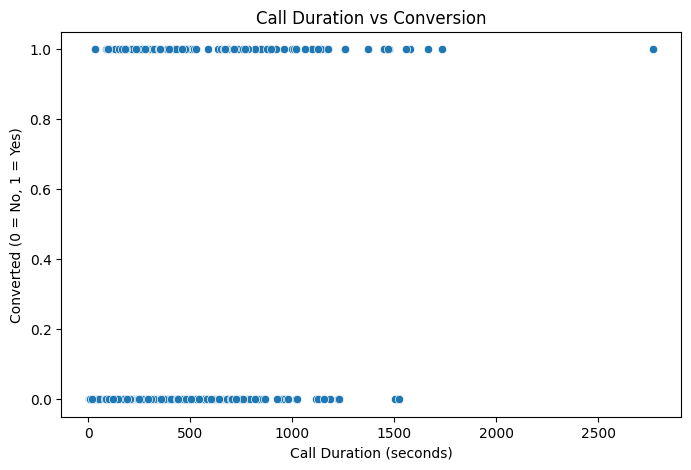

   education  avg_contacts  conversion_rate
0    primary      2.865782         0.094395
1  secondary      2.734172         0.106245
2   tertiary      2.901481         0.142963
3    unknown      2.486631         0.101604


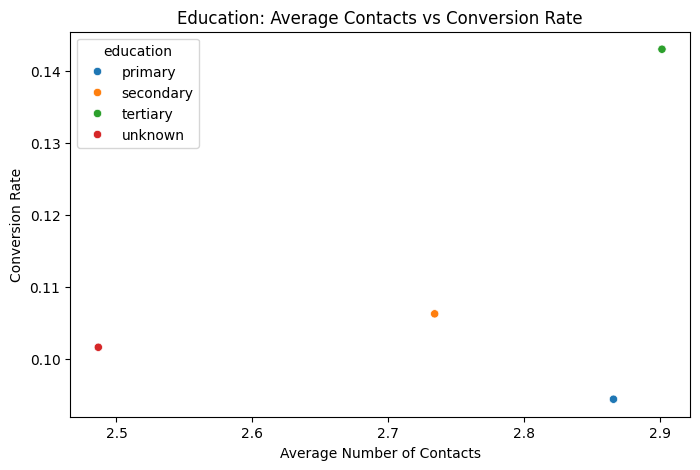

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

bank = pd.read_csv('bank.csv', sep=';')

#Defining: Conversion Rate - The proportion of customers who subscribed to a term deposit after the calls

#1) Overall conversion rate, no plot:
(bank["y"] == "yes").mean() #Conversion Rate: 11.5%

#2) Conversion rate by age groups:
age_bins = [0, 25, 35, 45, 55, 100]

bank["age_group"] = pd.cut(
    bank["age"],
    bins= age_bins,
    labels=["<25", "25–34", "35–44", "45–54", "55+"]
)

age_conv = (
    bank.groupby("age_group")["y"]
    .apply(lambda x: (x == "yes").mean())
    .reset_index(name="conversion_rate")
)
plt.figure(figsize=(8,5))

sns.barplot(
    data=age_conv,
    x="age_group",
    y="conversion_rate"
)
plt.title("Conversion Rate by Age Group")
plt.ylabel("Conversion Rate")
plt.xlabel("Age Group")
plt.show()

#Turns out that the conversion rate is highest for 0 - 24 age groups, around 20%

#3Does higher contact frequency lead to higher conversion rates? We use campaign as the frequency representative. Since campaign ranges from 1 - 10+, it is better to bin the data for better visualization.
#Surprisingly, the more contacts made, the lower the conversion rate.
bank["campaign_bin"] = pd.cut(
    bank["campaign"],
    bins=[0, 1, 2, 3, 5, 10, 50],
    labels=["1", "2", "3", "4–5", "6–10", "11+"]
)

bin_conv = (
    bank.groupby("campaign_bin")["y"]
    .apply(lambda x: (x == "yes").mean())
    .reset_index(name="conversion_rate")
)

plt.figure(figsize=(8,5))
sns.lineplot(
    data=bin_conv,
    x="campaign_bin",
    y="conversion_rate",
    marker="o"
)
plt.title("Conversion Rate by Contact Frequency (Binned)")
plt.xlabel("Number of Contacts")
plt.ylabel("Conversion Rate")
plt.show()

#4)Which job categories have the highest conversion rates?

#First of all, examine top 10 most common jobs:
top_jobs = bank["job"].value_counts().head(10).index 

job_conv = (
    bank[bank["job"].isin(top_jobs)]
    .groupby("job", observed=True)["y"]
    .apply(lambda x: (x == "yes").mean())
    .reset_index(name="conversion_rate")
    .sort_values("conversion_rate", ascending=False)
)


plt.figure(figsize=(8, 5))

sns.barplot(
    data=job_conv,
    x="conversion_rate",
    y="job"
)

plt.title("Conversion Rate by Job (Top 10 by Volume)")
plt.xlabel("Conversion Rate")
plt.ylabel("Job")
plt.show()

#Turns out that retired individuals have the highest conversion rate
#Note: Bar orientation is determined by which axis gets the numeric variable.

#5) Does longer call related to higher conversion rates?
#To solve this, take a sample from our dataset
sampled_bank = bank.sample(n=1000, random_state=99)
#Convert Yes, No to 1 and 0
sampled_bank["converted"] = (sampled_bank["y"] == "yes").astype(int)
plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=sampled_bank,
    x="duration",
    y="converted",
)

plt.title("Call Duration vs Conversion")
plt.xlabel("Call Duration (seconds)")
plt.ylabel("Converted (0 = No, 1 = Yes)")
plt.show()

#Results show that call duration does not have a significant impact on conversion rates, thought there are few cases such that longer calls result in higher conversion rates. And if the call is more than 1.5 seconds, it seems like a guaranteed yes
#6) Are some educational levels that are over-contacted but under-converted?
#To do this, we need to aggregate both contact frequency by education level

edu_stats = (
    bank.groupby("education")
    .agg(
        avg_contacts=("campaign", "mean"),#This 'mean' is the keyword, can replace with median,...
        conversion_rate=("y", lambda x: (x == "yes").mean())
    )
    .reset_index()
)
print(edu_stats)

plt.figure(figsize=(8, 5))

sns.scatterplot(
    data=edu_stats,
    x="avg_contacts",
    y="conversion_rate",
    hue="education",
)

plt.title("Education: Average Contacts vs Conversion Rate")
plt.xlabel("Average Number of Contacts")
plt.ylabel("Conversion Rate")
plt.show()

